# Advanced Machine Learning - programming assignment 4

*Due: Friday January 28*

**Please fill in:**
* Simon van de Fliert (5708656)
* Dirk Keller (4282264)

### Further instructions:
* Make sure your code is properly commented.
* Submit your code in Blackboard using one of your accounts; we will put the grade in Blackboard for the other team member as well.
* **Make sure to name the submitted file according to your and your collaborators last name.** (`submitter_collaborator.ipynb`)

## Implementing the PC algorithm
In this assignment, you will complete an implementation of the PC algorithm. After that, you will use it to discover causal relations in a data set. Each of these two parts is worth 5 points.

The PC algorithm will need to keep track of a PDAG. We will represent this PDAG by a numpy array `G` of booleans.

The matrix `G` represents a graph as follows:
* For all `x`, `G[x,x] == False`
* `G[x,y] == False` and `G[y,x] == False` means: no edge between x and y
* `G[x,y] == True` and `G[y,x] == True` means: an undirected edge x&mdash;y
* `G[x,y] == True` and `G[y,x] == False`means: a directed edge x$\to$y

In [2]:
import numpy as np
import itertools
import graphviz # Install with: conda install python-graphviz

from AML_assignment4_util import *

The graphviz can draw graphs to different file formats, or show them directly in the notebook. The function `graph_to_graphviz(G, node_names)` converts a numpy array of the form described above to a graph in graphviz format. 

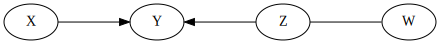

In [30]:
# Demonstration of graph_to_graphviz:
node_names = ['X', 'Y', 'Z', 'W']
G1 = np.zeros((4,4), dtype=bool)
G1[0,1] = G1[2,1] = True # two directed edges
G1[2,3] = G1[3,2] = True # an undirected edge
d = graph_to_graphviz(G1, node_names)
d # must be final line of code block to be displayed

Here is a Python class for performing the PC algorithm (when an object of this class is created and its `run` function is called). Add the missing code for phase 2, and implement phases 3 and 4. In the next section, you'll find some test cases to see if your code runs without errors and does what you expect it to.

In [50]:
class PC_algorithm:
    def __init__(self, independence_tester, verbose=1):
        # verbose can be 0 (silent), 1 (report independences), or 2 (also report dependences)
        self.independence_tester = independence_tester
        self.n = independence_tester.n_observed
        self.node_names = independence_tester.node_names
        self.verbose = verbose
        self.G = np.logical_not(np.eye(self.n, dtype=bool))
        self.sepset = dict()
    
    def skeleton_search(self):
        # PHASE II: Skeleton search
        # Note: Adj(X) in the slides means: all nodes adjacent to X in the current graph G
        
        # for conditioning size 
        for k in range(self.n-1):
            #for first node in pair
            for x in range(self.n):
                #for second node in pair
                for y in range(self.n):

                    if not self.G[x,y]:
                        continue
                    # Try all subsets S of Adj(x) \ {y} with |S|=k,
                    # until an independence is found.
                    # Hint: use itertools.combinations

                    # Your code here (1 point)

                    #============================================= ANSWER==============================================================

                    # get all adjacent nodes from X   
                    X_adjacent_nodes = [] 
                    
                    #loop through the edges of x 
                    for index, edge in enumerate(self.G[x]):
                        
                        # if the edge in self.G is true, then it means that there is an edge between x and the target
                        if edge:
                            #get the targets index                       
                            target_node = index
                            
                            # check that the target index is not the same as node y, as node y is not allowed to be in S
                            if target_node != y:
                                #save the index to loop through using itertools.combinations to create S
                                X_adjacent_nodes.append(target_node)

                    #========================================END ANSWER==============================================================
                    
                    #for all sets S where S is a subset of all adjacent nodes of X without the nodes in Y with the conditioning set sized at size k
                    for S in itertools.combinations(X_adjacent_nodes, k):
                        indep = self.independence_tester.test_independence(x, y, S)
                        if indep:
                            if self.verbose >= 1:
                                print("independence found: {0} and {1} given {{{2}}}"
                                      .format(self.node_names[x], self.node_names[y],
                                              ", ".join([self.node_names[v] for v in S])))
                            # Remove this edge.
                            self.G[x,y] = self.G[y,x] = False
                            # We use frozensets as keys in the dictionary self.sepset,
                            # because ordinary sets can't be used as keys to dictionaries.
                            self.sepset[frozenset([x,y])] = S
                            break
                        else:
                            if self.verbose >= 2:
                                print("dependence found: {0} and {1} given {{{2}}}"
                                      .format(self.node_names[x], self.node_names[y],
                                              ", ".join([self.node_names[v] for v in S])))

            # Do we need to continue with larger k?
            max_S_size = np.sum(self.G, axis=0) - 1
            if np.all(max_S_size < k + 1):
                break
        return

    def orient_v_structures(self):
        # PHASE III: Orient v-structures
        # Something to watch out for:
        # If the data are not faithful to any graph, the algorithm may end up trying
        # to orient a single edge in two different ways. You can choose either
        # orientation if this happens. But make sure not to accidentally delete such an edge!

        # to save the colliders found in each for loop instance. Saved to take it out of the for loop to change the graph
        total_colliders = []
        # to save the created collider after changing the graph
        created_collider = []

        paths_all_independencies = self.get_current_paths()

        for index, independence_info in enumerate(paths_all_independencies):  
            
            path = independence_info[0]
            Independence_keys = independence_info[1]
            Independence_conditioning_set = independence_info[2]
            

            if len(Independence_conditioning_set)==0:
                colliders = []

                # Each node that is between the start node and end node with an empty set S can be a collider, we will check if it is so below
                potential_colliders = path[1:-1]

                # if a collider is found, then the previous node and next node must not be a collider
                skipped_collider = []

                for pc_index, potential_collider in enumerate(potential_colliders):

                    # if potential_colliders length == 1 --> that node has to be a collider
                    if len(potential_colliders) == 1:
                        colliders.append((Independence_keys, potential_collider))

                    #elif check if there already is a collider in the path
                    elif len(potential_colliders) > 1:
                        # check if node is in the skipped colliders if so, then pass and do nothing
                        if potential_collider in skipped_collider:
                            pass

                        #check if node is a known collider
                        else:
                            # if so then the next node must be skipped --> Impossible to have a two directed edge in a DAG (Not taking into account MAGs from later lectures)                            
                            skipped_collider.append(potential_colliders[pc_index+1])
                            
                            # if so then this must also be saved to colliders
                            colliders.append((Independence_keys, potential_collider))
                
                
                # Save the collider combinations in a list outside of the loop, so that we can change the graph outside the loop (if the change is done inside the loop, then adjacency nodes will be incorrect)
                for chosen_collider in colliders:
                    if chosen_collider[1] not in total_colliders:
                        total_colliders.append(chosen_collider)

        # change the graph
        for total_collider in total_colliders:
            #make sure that the collider has not already been made
            if total_collider[1] not in created_collider:
                start_node = total_collider[0][0]
                target_node = total_collider[0][1]
                collider = total_collider[1]

                #change the graph such that there are incoming directed edges towards the collider
                self.G[start_node, collider] = self.G[target_node, collider] = True #create two directed edges
                #make sure that the outgoing edges of the collider are not directed
                self.G[collider, start_node] = self.G[collider, target_node] = False #make sure the edge is not univariant
                created_collider.append(total_collider[1])
    
        ### ================== CHAIN + FORKS =============================================
        # if value of sepset is not empty, then we condition on a non-empty set. This means that there is either a chain or a fork, as a path can only be blocked by conditioning if the path is forked or in a chain. 
        
        for index, CF_independence_info in enumerate(paths_all_independencies):  
            edge_directions_forks_chains = []
            path = CF_independence_info[0]
            Independence_keys = CF_independence_info[1]
            Independence_conditioning_set = CF_independence_info[2]

        

            if len(Independence_conditioning_set) >= 1:

                # Get the path corresponding to the independence
                starting_node = Independence_keys[0]
                target_node = Independence_keys[1]
                # get the index to the corresponding conditioned variable
                # Independence_conditioning_set = Z --> index halen corresponderend met Z
                 
                index_conditioned_variable = Independence_conditioning_set[0]

                print(f'PATH: {path}')
                arrows = self.get_arrow_direction(index_conditioned_variable, starting_node, target_node)

                # if one of the arrows is undirectional, then the other edge cannot be undirectional. Furthermore, if one of the edges is directed towards the conditioned node, then the other edge has to be directed away from the conditioned. 
                # So, We only need to check if one of the edges is pointed towards the conditioned node. If it is not, then the result could be either a fork or a chain. In that case we will need to decide with Step IV.
                if arrows[0] == 'un_dir':
                    if arrows[1] == 'target_con':
                        #arrow has to point away from the conditioned node to avoid a collider
                        arrows[0] = 'con_start'                 
                if arrows[1] == 'un_dir':
                    if arrows[0] == 'start_con':
                        arrows[1] == 'con_target'
                
                #save the directions for use outside the for-loop
                edge_directions_forks_chains.append(arrows)
                
            # change the graph
            for edges in edge_directions_forks_chains:
                first_edge = edges[0]
                second_edge = edges[1]

                #if first_edge == 'start_con':   
                #    self.G[starting_node, index_conditioned_variable] = True  #start_node -> conditioned_var
                #    self.G[index_conditioned_variable, starting_node] = False #start_node </- conditioned_var
                #elif first_edge == 'con_start':
                #    self.G[starting_node, index_conditioned_variable] = False #start_node -/> conditioned_var
                #    self.G[index_conditioned_variable, starting_node] = True  #start_node <- conditioned_var

                #if second_edge == 'con_target':
                #    self.G[index_conditioned_variable, target_node] = True  #conditioned_var --> target_node
                #    self.G[target_node, index_conditioned_variable] = False #conditioned_var <-/- target node
                #elif second_edge == 'target_con':
                #    self.G[index_conditioned_variable, target_node] = False  #conditioned_var -/-> target node
                #    self.G[target_node, index_conditioned_variable] = True #conditioned_var <-- target node





                # if edge is directed from start to the conditioned node, we know that the edge from the conditioned node to the target must be directed towards the target, otherwise we get a collider and not a fork or chain
                if first_edge == 'start_con':   
                    self.G[index_conditioned_variable, target_node] = True  #conditioned_var --> target_node
                    self.G[target_node, index_conditioned_variable] = False #conditioned_var <-/- target node

                # do nothing if edge is con_start
                elif first_edge == 'con_start':
                    pass
                    #self.G[starting_node, index_conditioned_variable] = False #start_node -/> conditioned_var
                    #self.G[index_conditioned_variable, starting_node] = True  #start_node <- conditioned_var

                if second_edge == 'con_target':
                    pass

                elif second_edge == 'target_con':
                    self.G[starting_node, index_conditioned_variable] = True  #start_node -> conditioned_var
                    self.G[index_conditioned_variable, starting_node] = False #start_node </- conditioned_var


        # Your code here (2 points)
        return
    
    def orientation_rules(self):
        # PHASE IV: Orientation rules

        # Your code here (2 points)
        return   
    
    def run(self):
        # The initialization step has already been performed by the __init__ method.
        # Perform the other phases one by one. Each of the following functions
        # modifies self.G, which represents the graph.
        self.skeleton_search()
        self.orient_v_structures()
        self.orientation_rules()

        return self.G



    # ========================================================================================= HELPER FUNCTIONS TO LOWER THE AMOUNT OF CODE PER FUNCTION =========================================================================================

    def get_arrow_direction(self, index_conditioned_variable, starting_node, target_node):
        """
        Function to get the arrow directions, seperated from main code due to ugliness.
        
        """
        directions_arrows = ['arrow1', 'arrow2']
        print(f'index_conditioned_variable: {index_conditioned_variable}')
        print(f'starting_node: {starting_node}')
        print(f'target_node: {target_node}')
        print(f'start_con {self.G[starting_node, index_conditioned_variable]}')
        print(f'con_start {self.G[index_conditioned_variable, starting_node]}')
        print(f'con_Target: {self.G[index_conditioned_variable, target_node]}')
        print(f'target_con {self.G[target_node, index_conditioned_variable]}')
        
        # Undirectional edge from start -- conditioned variable
        if self.G[starting_node, index_conditioned_variable] == True:
            
            if self.G[index_conditioned_variable, starting_node] == True: directions_arrows[0] = "un_dir"
            
            else: directions_arrows[0] = 'start_con'  

        else: directions_arrows[0] = 'con_start' 
        
        # Undirectional edge from conditioned variable - target
        if self.G[index_conditioned_variable, target_node] == True:
            
            if self.G[target_node, index_conditioned_variable] == True: directions_arrows[1] = "un_dir"
            
            else: directions_arrows[1] = 'con_target'
        
        else: directions_arrows[1] = 'target_con'  

        return directions_arrows

    
    def get_current_paths(self):
        """
        Goal: This function calculates for each combination of frozensets and nodes that have been conditioned on the path that the graph should take. 
        Returns: This function then returns said path, the frozenset belonging to said path and the conditioned nodes found in the path.
        Used for: finding the colliders, forks and chains in function orient_v_structures to update the edge directions
        """

        list_of_paths = []

        for index, frozen_set_independent_nodes in enumerate(self.sepset):  
         # Here we use the stored conditioning sets that we saved

            #if value of sepset is empty, then we conditioned on an empty set. THis means that there is a collider, as only then can the path be blocked and thus the nodes in the key be independent of each other
            Independence_keys = list(frozen_set_independent_nodes)
            Independence_conditioning_set = self.sepset.get(frozen_set_independent_nodes)

            # Get the path corresponding to the independence
            starting_node = Independence_keys[0]
            target_node = Independence_keys[1]
            #initialize current path with the first node
            current_path = [starting_node]
            # for each node on the path, check which nodes are adjacent to it
            for nodes in current_path:
                for index, adjacent_node in enumerate(self.G[nodes]):
        
                    # if the node is adjacent, not the target node, and not in the current path, add the index of the node to the path. The target node check is done in the if loop above
                    if adjacent_node and index not in current_path:
                        current_path.append(index)

                # if the node is an adjacent node and it is the target node, then add the target node to the path and end the loop
                if nodes == target_node:
                        break

            # The path stops at the target node, thus we need to find the index of the target node and then index the current path on that index                
            target_node_index_in_current_path = current_path.index(target_node)
            updated_current_path = current_path[:target_node_index_in_current_path+1]

            #save the path, frozen set and conditioned nodes
            list_of_paths.append([updated_current_path, Independence_keys, Independence_conditioning_set])

        return list_of_paths


    

* `G[x,y] == True` and `G[y,x] == True` means: an undirected edge x&mdash;y
* `G[x,y] == True` and `G[y,x] == False`means: a directed edge x$\to$y

  # Here we use the stored conditioning sets that we saved

            #if value of sepset is empty, then we conditioned on an empty set. THis means that there is a collider, as only then can the path be blocked and thus the nodes in the key be independent of each other
            Independence_keys = list(frozen_set_independent_nodes)
            Independence_conditioning_set = self.sepset.get(frozen_set_independent_nodes)


            # Get the path corresponding to the independence
            starting_node = Independence_keys[0]
            target_node = Independence_keys[1]
            #initialize current path with the first node
            current_path = [starting_node]
            # for each node on the path, check which nodes are adjacent to it
            for nodes in current_path:
                for index, adjacent_node in enumerate(self.G[nodes]):
        
                    # if the node is adjacent, not the target node, and not in the current path, add the index of the node to the path. The target node check is done in the if loop above
                    if adjacent_node and index not in current_path:
                        current_path.append(index)

                # if the node is an adjacent node and it is the target node, then add the target node to the path and end the loop
                if nodes == target_node:
                        break

            # The path stops at the target node, thus we need to find the index of the target node and then index the current path on that index                
            target_node_index_in_current_path = current_path.index(target_node)
            updated_current_path = current_path[:target_node_index_in_current_path+1]

            
            # Save the paths, conditioning sets and size conditioning set in list
            # This can be later used to loop through
            # -- for index, frozen_sets in enumerate(self.sepset): --> can be a seperate function to get the list of lists containing path, set and size set
            #       for information in (list):
            #           if information[3] == 1:
            #               call function for colliders
            #           if information[3] >= 1:
            #               call function for chains and forks

            #       maybe need a seperate function for plotting the graph


# change the graph
        #for total_collider in total_colliders:
                                    #make sure that the collider has not already been made
        #    if total_collider[1] not in created_collider:
        #        start_node = total_collider[0][0]
        #        target_node = total_collider[0][1]
        #        collider = total_collider[1]

                                    #change the graph such that there are incoming directed edges towards the collider
        #        self.G[start_node, collider] = self.G[target_node, collider] = True #create two directed edges
                                    #make sure that the outgoing edges of the collider are not directed
        #        self.G[collider, start_node] = self.G[collider, target_node] = False #make sure the edge is not univariant
        #        created_collider.append(total_collider[1])


  # Undirectional edge from start -- conditioned variable
                if self.G[starting_node, index_conditioned_variable] == True and self.G[index_conditioned_variable, starting_node] == True:
                    
                    #check the edge of conditioned variable -- target
                    # Directional edge from conditioned variable -> target
                    if self.G[index_conditioned_variable, target_node] == True and self.G[target_node, index_conditioned_variable] == False:
                        pass
                    
                    # Directional edge from conditioned variable <- target
                    else:
                        pass

                    

                # Directional edge from start -> conditioned variable
                elif self.G[starting_node, index_conditioned_variable] == True and self.G[index_conditioned_variable, starting_node] == False:
                    pass
                
                # Directional edge from start <- conditioned variable
                else:
                    pass
                
                
                
                # ==================== Check direction edge between conditioned variable and target ===============================

                # Undirectional edge from start -- conditioned variable
                if self.G[index_conditioned_variable, target_node] == True and self.G[target_node, index_conditioned_variable] == True:
                    pass


                # Directional edge from conditioned variable -> target
                elif self.G[index_conditioned_variable, target_node] == True and self.G[target_node, index_conditioned_variable] == False:
                    pass
                
                # Directional edge from conditioned variable <- target
                else:
                    pass
                    





print(f'created_collider {created_collider}')
                for chosen_collider in colliders:

                    if chosen_collider[1] not in created_collider:
                        start_node = chosen_collider[0][0]
                        target_node = chosen_collider[0][1]
                        collider = chosen_collider[1]

                        print(f'chosen_collider start node {chosen_collider[0][0]}')
                        print(f'chosen_collider target node {chosen_collider[0][1]}')
                        print(f'chosen_collider collider {chosen_collider[1]}')
                        self.G[start_node, collider] = self.G[target_node, collider] = True #create two directed edges
                        #self.G[collider, start_node] = self.G[collider, target_node] = False #create two directed edges
                        created_collider.append(chosen_collider[1])
                    else:
                        pass
                    
                    print(f'chosen_collider[1] {chosen_collider[1]}')
                    print(f'created_collider {created_collider}')


## Testing the PC implementation

To verify that the algorithm is working correctly, we will feed it output from an *oracle* instead of conditional independence test results from a data set. The oracle knows what the true graph is, and mimics the conditional independence test results that we would get for data that is Markov and faithful to that graph. In this situation, the PC algorithm will recover the Markov equivalence class of the true graph.

In [14]:
class IndependenceOracle:
    def __init__(self, true_G, node_names, n_observed=None):
        self.G = true_G
        self.n = true_G.shape[0]
        self.n_observed = n_observed if n_observed is not None else self.n
        self.node_names = node_names
    def test_independence(self, x, y, S):
        S_mask = np.zeros(self.n, dtype=bool)
        np.put(S_mask, S, True)
        return is_d_separated(self.G, x, y, S_mask)

We will compare the output of PC to the oracle's true graph for the graph `G1` we saw before, and for several other graphs. (You can add more tests to help chase down any bugs.)

In [ ]:
oracle = IndependenceOracle(G1, node_names)
A = PC_algorithm(oracle, verbose=2)
G = A.run()
print("PASS" if np.all(G == G1) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

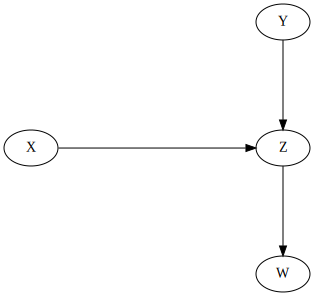

In [37]:
G2 = np.zeros((4,4), dtype=bool)
G2[0,2] = G2[1,2] = G2[2,3] = True
graph_to_graphviz(G2, node_names)

In [ ]:
oracle = IndependenceOracle(G2, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G2) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

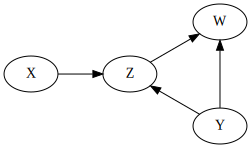

In [39]:
G3 = np.zeros((4,4), dtype=bool)
G3[0,2] = G3[1,2] = G3[1,3] = G3[2,3] = True
graph_to_graphviz(G3, node_names)

independence found: X and Y given {}
independence found: W and X given {Y, Z}
PATH: [0, 2, 1, 3]
index_conditioned_variable: 1
starting_node: 0
target_node: 3
start_con False
con_start False
con_Target: True
target_con True
FAIL


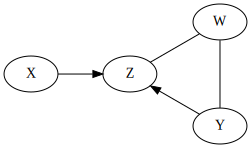

In [53]:
oracle = IndependenceOracle(G3, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G3) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

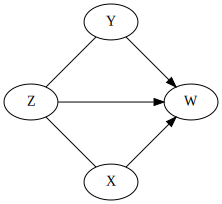

In [41]:
G4 = np.logical_not(np.eye(4, dtype=bool))
G4[0,1] = G4[1,0] = False
G4[3,0] = G4[3,1] = G4[3,2] = False
graph_to_graphviz(G4, node_names)

independence found: X and Y given {Z}
PATH: [0, 2, 3, 1]
index_conditioned_variable: 2
starting_node: 0
target_node: 1
start_con True
con_start True
con_Target: True
target_con True
FAIL


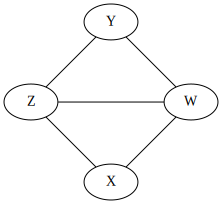

In [54]:
oracle = IndependenceOracle(G4, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G4) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

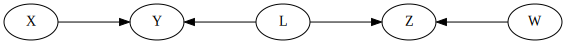

In [56]:
# Example of a case for which no DAG exists that is Markov and faithful to the distribution.
# L is a latent variable that the PC algorithm won't know about. PC's output should be either
# X --> Y --> Z <-- W or
# X --> Y <-- Z <-- W.
# If there is no edge between Y and Z in your output, this most likely indicates a bug in
# your implementation of phase III.
G5 = np.zeros((5,5), dtype=bool)
G5[0,1] = G5[4,1] = True
G5[3,2] = G5[4,2] = True
graph_to_graphviz(G5, ['X', 'Y', 'Z', 'W', 'L'])

independence found: X and Z given {}
independence found: X and W given {}
independence found: Y and W given {}
FAIL


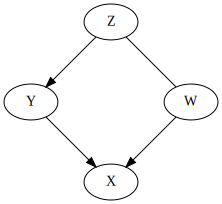

In [57]:
oracle = IndependenceOracle(G5, node_names, n_observed = 4)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if G[0,1] and G[3,2] and (G[1,2] or G[2,1]) and np.sum(G) == 3 else "FAIL")
graph_to_graphviz(G, oracle.node_names)

## Running PC on data
In this second part of the assignment, you will apply the PC algorithm to the biological dataset of Sachs et al. (2005). In this dataset, the columns represent 11 different proteins, which were measured in thousands of human immune system cells. Each row is a single cell. The cells were prepared in different ways, by adding different chemicals some time before the measurements were made. A twelfth column, labeled `experiment`, indicates in which way that cell was prepared. We can think of `experiment=1` as denoting the observational data, and other values of `experiment` (2 through 14) as various interventional datasets.

In [3]:
import pandas as pd

all_data = pd.read_csv("sachs2005_combined.csv", sep='\t')
# Transform all columns except 'experiment' by taking the logarithm of 10 + the original value
all_data.loc[:, all_data.columns != 'experiment'] = np.log(10 + all_data.loc[:, all_data.columns != 'experiment'])

We will apply the PC algorithm to just the observational data.

Make a new dataframe containing only the data where experiment equals 1. Remove the `experiment` column from this dataframe. Check the shape of your dataframe: it should be `(853, 11)`.

In [4]:
# Your code here (0.5 point)
exp1_data = all_data[all_data['experiment'] == 1].drop('experiment', 1)

print(exp1_data.shape)

exp1_data.head(-5)

(853, 11)


C:\Users\Simon\AppData\Local\Temp/ipykernel_1368/163335404.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  exp1_data = all_data[all_data['experiment'] == 1].drop('experiment', 1)


,praf,pmek,plcg,PIP2,PIP3,perk,pakts473,PKA,PKC,P38,pjnk
0,3.594569,3.144152,2.934920,3.342862,4.231204,2.810005,3.295837,6.049733,3.295837,4.005513,3.912023
1,3.826465,3.277145,3.104587,3.288402,2.897568,3.353407,3.749504,5.891644,2.593013,3.277145,4.269697
2,4.239887,3.990834,3.202746,3.005683,3.135494,3.214868,3.749504,6.023448,3.063391,3.735286,3.384390
3,4.418841,4.530447,3.499533,3.157000,2.423917,2.761907,3.081910,6.287859,3.165475,3.653252,3.499533
4,3.777348,3.394508,2.720637,2.982140,3.549617,3.437208,4.027136,5.752573,2.685123,3.575151,4.514151
...,...,...,...,...,...,...,...,...,...,...,...
843,3.569533,3.144152,3.475067,3.122365,3.749504,2.885359,3.720862,5.978886,3.238678,3.688879,4.546481
844,3.756538,3.117950,3.104587,3.325036,4.065602,3.660994,4.117410,6.695799,3.025291,3.306887,2.862201
845,3.384390,4.087656,2.778819,3.261935,3.640214,3.306887,3.728100,6.490724,3.430756,4.005513,3.288402
846,4.036009,3.468856,3.317816,3.613617,3.234749,4.284965,4.692265,7.641084,3.377588,3.875359,3.563883


For the next part, you will need to install the package [tigramite](https://github.com/jakobrunge/tigramite). Here are three different ways in which you might be able to install it, in the order in which we recommend you to try them:

1. `conda install -c egilliesix tigramite`

2. `conda install git pip`  
`pip install git+git://github.com/jakobrunge/tigramite.git`

3. If not in a conda environment, follow the README on github.

To run the PC algorithm on data, we need to perform (conditional) independence tests. Tigramite implements several such tests. The simplest of these tests is `ParCorr()`. It assumes the data come from a linear structural causal model, which they actually don't. We will use it anyway, because the alternatives (such as `CMIknn()` (Runge, 2018)) are more effort to install and orders of magnitude slower, while `ParCorr()` usually already gives decent results.

As a statistical test, a conditional independence test works by computing a p-value. If a conditional independence exists, this p-value will be approximately uniformly distributed on the interval between 0 and 1. If the variables being tested are conditionally dependent, the p-value will be close to 0. PC wants to know a binary answer, so we will pick some threshold alpha and declare an independence if the p-value is larger than alpha.

In statistical testing, alpha is often taken to be 0.05 or smaller. For PC, it may be more appropriate to pick a larger alpha instead. This is because as soon as PC finds a (conditional) independence between two variables, it will delete the edge between them and do no more tests between those two variables. If this happens while it shouldn't have, PC can't put the edge back. But in the reverse situation, if PC leaves an edge in place while it should have deleted it, there is still a possibility that the edge will be deleted later, when another test between those two variables reports a more convincing independence.

In [5]:
from tigramite.independence_tests import ParCorr#, CMIknn
import tigramite.data_processing as pp
# Importing these may give some warnings (e.g. 'Could not import r-package RCIT'),
# but most of these warnings can be ignored because we are not using the mentioned packages.

class IndependenceTester:
    def __init__(self, data, cond_ind_test, alpha, verbose=2, n_observed=None):
        # data: a pandas dataframe
        # cond_ind_test: an independence test from tigramite, e.g. ParCorr()
        # alpha: the significance level to which the p-values are compared
        
        # tigramite uses its own kind of dataframe, so convert the data to that format
        df_tigramite = pp.DataFrame(data.to_numpy(), var_names=data.columns)
        self.cond_ind_test = cond_ind_test
        self.cond_ind_test.set_dataframe(df_tigramite)
        self.n = data.shape[1]
        self.n_observed = n_observed if n_observed is not None else self.n
        self.verbose = verbose
        self.node_names = data.columns
        self.alpha = alpha
    def test_independence(self, x, y, S):
        val, pval = self.cond_ind_test.run_test(X=[(x, 0)],
                                                Y=[(y, 0)],
                                                Z=[(z, 0) for z in S])
        test_result = pval > self.alpha
        if self.verbose >= 2 or (self.verbose >= 1 and test_result):
            print("test: {0} and {1} given {2} -> pval={3}".format(self.node_names[x], self.node_names[y],
                                                                   ", ".join([self.node_names[v] for v in S]),
                                                                   pval))
        return test_result

C:\Users\Simon\Anaconda3\envs\AdMlAs4\lib\site-packages\tigramite\independence_tests\gpdc.py:16: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
C:\Users\Simon\Anaconda3\envs\AdMlAs4\lib\site-packages\tigramite\independence_tests\gpdc_torch.py:18: UserWarning: No module named 'dcor'
  warnings.warn(str(e))


Using an IndependenceTester object (which works similarly to the IndependenceOracle we used earlier), run the PC algorithm on the observational data. Display the graph that comes out. You may experiment with different values of alpha; the graph you get should either be connected (i.e. consist of one connected component), or have just two connected components.

In [ ]:
# Your code here (1 point)

Now let's look at what else is in the dataset: the interventional data corresponding to different experiments. The PC algorithm did not look at this part of the dataset, but these additional experiments can obviously provide valuable information about the causal graph. In the following questions, we will investigate two examples of this. We will use the output of the PC algorithm to give us a rough idea of what the causal graph might look like.

The interventions in these experiment are not perfect interventions: they change the structural equation of a variable, but not by setting it to a constant. The new structural equation in the intervened model may still include all variables that were there in the original model. So in the graph of the intervened model, all arrows will still be there.

Further, some of the interventions change not one, but multiple structural equations.

For some of the interventions in the data, here is what they do according to many (but not all) experts:
* experiment 5 adds the substance psitectorigenin, which modifies the amount of PIP2;
* experiment 6 adds the substance U0126, which increases the *activity* of pmek. This means that the amount of pmek is not changed by the intervention, but for all *children* of pmek in the causal model, the structural equation changes to reflect that pmek now has a stronger effect on them. pmek is believed to have only one child in the true causal model, namely perk.

(Source: Mooij et al., 2019, specifically Tables 2 & 3 and Figure 35(a))

Create two new dataframes, one containing all data from experiments 1 and 5, and one with the data from experiments 1 and 6. These dataframes should still have an 'experiment' column, so that you can tell for each row whether it came from the observational or the interventional dataset.

In [ ]:
# Your code here (0.5 point)

**Question (1.5 points)**: In the dataframe for experiments 1 and 5, look at PIP2 and a variable adjacent to it in the output of PC (if there is more than one, pick one). Using about 200 words, answer the following questions: Based on looking at one or more plots (like scatterplots or histograms), which do you find more likely: that psitectorigenin directly modifies PIP2, or the neighbouring variable, or both? And what does the data for the two experiments seem to say about the direction of the arrow between PIP2 and its neighbour?

Insert one or more markdown and code boxes below here to give your answer and the plots you base your answer on. (Please put your answer in markdown boxes, not as comments in your code!)

**Question (1.5 points)**: In the dataframe for experiments 1 and 6, look at pmek, perk, and any other variables adjacent to pmek in the output of PC. Assume it is true that adding U0126 produces an intervention on the *activity* of pmek. What would you expect to see in the data if the graph found by PC was correct? Would you propose any changes to that graph based on the data?

Again put your answer (about 200 words) with accompanying plots in new boxes below here.

---

You are almost done! Before handing in, make sure that the code you hand in works, and that all plots are shown. **Submit just one file per team.** Name the submitted file according to your and your collaborator's last name (`submitter_collaborator.ipynb`).

### References
* J. M. Mooij, S. Magliacane, and T. Claassen, "Joint Causal Inference from Multiple Contexts," [arXiv:1611.10351v4](https://arxiv.org/abs/1611.10351), 2019.
* J. Runge, "Conditional Independence Testing Based on a Nearest-Neighbor Estimator of Conditional Mutual Information" In Proceedings of the 21st International Conference on Artificial Intelligence and Statistics, http://proceedings.mlr.press/v84/runge18a.html, 2018.
* K. Sachs, O. Perez, D. Pe’er, D. A. Lauffenburger, and G. P. Nolan, "Causal protein-signaling networks derived from multiparameter single-cell data," Science, vol. 308, no. 5721, pp. 523–529, 2005.